In [3]:
from config import config
from env.v0d0 import Env
from policy.v0d0 import Model
import torch
import time
from scipy.io.wavfile import write
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

/home/kongxiangyu/anaconda3/envs/ss/lib/python3.9/site-packages/tqdm-4.66.1-py3.9.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-25 08:12:07.451402: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 08:12:07.471534: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 08:12:07.471560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

In [2]:
import sys
import argparse

# 手动设置 sys.argv，避免 Jupyter 自带参数
sys.argv = ['script_name', '--forward_amount', '0.5']

parser = argparse.ArgumentParser()
parser.add_argument('--forward_amount', type=float, help='前进的距离')

args = parser.parse_args()

print(f"Forward Amount: {args.forward_amount}")


Forward Amount: 0.5


In [4]:
import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

from habitat.utils.visualizations import maps

import random
random.seed(42)

In [6]:
def display_obs(obs):
    from habitat_sim.utils.common import d3_40_colors_rgb
    rgb_obs1, rgb_obs2 = obs[0]["camera"], obs[1]["camera"]
    rgb_img1 = Image.fromarray(rgb_obs1, mode="RGBA")
    rgb_img2 = Image.fromarray(rgb_obs2, mode="RGBA")

    arr = [rgb_img1, rgb_img2]
    titles = ["rgb1", "rgb2"]

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

def convert_points_to_topdown(pathfinder, points, meters_per_pixel=0.01):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)


def get_td_map(pathfinder, meters_per_pixel=0.01, vis_points=None):

    height = pathfinder.get_bounds()[0][1]
    xy_vis_points = None

    if vis_points is not None:
        xy_vis_points = convert_points_to_topdown(
            pathfinder, vis_points, meters_per_pixel
        )

    hablab_topdown_map = maps.get_topdown_map(
        pathfinder, height, meters_per_pixel=meters_per_pixel
    )
    recolor_map = np.array(
        [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
    )
    hablab_topdown_map = recolor_map[hablab_topdown_map]

    return hablab_topdown_map, xy_vis_points


In [7]:
env = Env(config)

[08:12:23:382804]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[08:12:23:382881]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[08:12:23:382906]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[08:12:23:382924]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[08:12:23:382941]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_s

[08:12:23:383606]:[Metadata] SceneDatasetAttributesManager.cpp(308)::readDatasetJSONCell : "stages.default_attributes" set in Attributes Manager from JSON.
[08:12:23:383655]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for ../data/scene_datasets/mp3d/*/*.glb : ../data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb
[08:12:23:383751]:[Metadata] SceneInstanceAttributesManager.cpp(65)::setValsFromJSONDoc : No Stage specified for scene default_attributes , or specification error.
[08:12:23:383759]:[Metadata] SceneInstanceAttributesManager.cpp(105)::setValsFromJSONDoc : No Articulated Objects specified for scene default_attributes , or specification error.
[08:12:23:383765]:[Metadata] SceneInstanceAttributesManager.cpp(125)::setValsFromJSONDoc : No navmesh_instance specified for scene default_attributes .
[08:12:23:383771]:[Metadata] SceneInstanceAttributesManager.cpp(135)::setValsFromJSONDoc : No semantic_scene_instance specified for scene de

 attributes (cylinderWireframe:cylinderWireframe_rings_1_segments_32_halfLen_1) created and registered.
[08:12:23:383428]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (icosphereSolid:icosphereSolid_subdivs_1) created and registered.
[08:12:23:383441]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (icosphereWireframe:icosphereWireframe_subdivs_1) created and registered.
[08:12:23:383454]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (uvSphereSolid:uvSphereSolid_rings_8_segments_16_useTexCoords_false_useTangents_false) created and registered.
[08:12:23:383466]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (uvSphereWireframe:uvSphereWireframe_rings_16_segments_32) created and registered.
[08:12:23:383476]:[Metadata] AssetAttributesManager.cpp(110)::AssetAttributesManager : Built default primitive asset templates : 12
[08:12:23:383671]:[Metadata] AttributesManagerBase.h(2

In [8]:
obs = env.reset()

source_poses [array([-2.6478825,  0.072447 , -1.1744175], dtype=float32)]
agent 0 reseting
[08:12:32:572522]:[Sensor] AudioSensor.cpp(86)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(-2.64788, 0.072447, -1.17442) ]
[08:12:32:572571]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
CreateContext: Context created
[08:12:32:572790]:[Sensor] AudioSensor.cpp(86)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(-2.64788, 0.072447, -1.17442) ]
[08:12:32:572805]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
CreateContext: Context created
agent 0 initialization retried.
agent_state.position [0.9786967  0.072447   0.37796375]
agent 1 reseting
agent_state.position [-9.130758   0.072447  -0.9648434]


Material for category 'picture' was not found. Using default material instead.
Material for category 'objects' was not found. Using default material instead.
Material for category 'void' was not found. Using default material instead.
Material for category 'misc' was not found. Using default material instead.
Material for category 'picture' was not found. Using default material instead.
Material for category 'objects' was not found. Using default material instead.
Material for category 'void' was not found. Using default material instead.
Material for category 'misc' was not found. Using default material instead.


[08:12:32:576777]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(0.978697, 0.072447, 0.377964) ], rotQuat[ Vector(1, 0, 0, 0) ]
[08:12:32:576823]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:12:32:576835]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:12:32:576841]:[Sensor] AudioSensor.cpp(135)::runSimulation : [Audio]  New initialization, will upload geometry
[08:12:32:576846]:[Sensor] AudioSensor.cpp(139)::runSimulation : [Audio]  Loading semantic scene
[08:12:32:576852]:[Sensor] AudioSensor.cpp(361)::loadSemanticMesh : [Audio]  Loading semantic mesh true
[08:12:32:995142]:[Sensor] AudioSensor.cpp(450)::loadSemanticMesh : [Audio]   Index count:  77148 , Material:  shelving
[08:12:32:995579]:[Sensor] AudioSensor.cpp(450)::loadSemanticMesh : [Audio]   Index count:  404010 , Material:  chair
[08:12:32:995903]:[Sensor] AudioSensor.cpp(

In [9]:
from utils.angles import *
import math

def add_agent_pos_angle(pathfinder, top_down_graph, agent_pos, agent_q):
    agent_angle = quat_to_angle(agent_q)
    show_angle = math.atan2(agent_angle[0], agent_angle[2])
    grid_dimensions = (top_down_graph.shape[0], top_down_graph.shape[1])

    grid_pos = maps.to_grid(
        agent_pos[2],
        agent_pos[0],
        grid_dimensions,
        pathfinder=pathfinder,
    )

    maps.draw_agent(
        top_down_graph, grid_pos, show_angle, agent_radius_px=16
    )

    return top_down_graph


In [10]:
def show_graph(env):
    source_pos = env.get_source_pos()
    agent_pos = env.get_agent_pos()
    vis_points = source_pos
    x, y = get_td_map(env._sim.pathfinder, vis_points=vis_points)
    agent_r = env.get_agent_rotation()

    for agent_id in range(2):
        x = add_agent_pos_angle(env._sim.pathfinder, x, agent_pos[agent_id], agent_r[agent_id])

    display_map(x,y)

In [20]:
# def act(env, action):
#     # at probability eps, take random action
#     # otherwise, take best action
    
#     ret = list()
#     num_agents = env.get_num_agents()
#     for agent_id in range(num_agents):
#         ret.append(
#             {
#                 "rl_pred": action,
#                 "lstm_h": np.zeros((512,), np.float32),
#                 "lstm_c": np.zeros((512,), np.float32),
#             }
#         )
    
#     return ret
def act(env,paths,idx):
    # at probability eps, take random action
    # otherwise, take best action
    ret = list()
    num_agents = env.get_num_agents()
    for agent_id in range(num_agents):
        if _idx >= len(paths[agent_id]):
            action = "stop"
        else:
            action = paths[agent_id][_idx]
        print("agent", agent_id, action)

        act_id = env.action_str_2_id(action)

        ret.append(
            {
                "rl_pred": act_id,
                "lstm_h": np.zeros((512,), np.float32),
                "lstm_c": np.zeros((512,), np.float32),
            }
        )

    return ret

id2str = {
    0: "move_forward",
    1: "turn_left",
    2: "turn_right",
    3: "stop",
}

str2id = {
    "move_forward": 0,
    "turn_left": 1,
    "turn_right": 2,
    "stop": 3,
}

paths = env.get_shortest_action_list()
print(paths)

[['turn_left', 'turn_left', 'turn_left', 'turn_left', 'move_forward', 'turn_left', 'move_forward', 'turn_right', 'move_forward', 'move_forward', 'move_forward', 'stop'], ['turn_right', 'turn_right', 'turn_right', 'turn_right', 'move_forward', 'move_forward', 'move_forward', 'stop']]


In [12]:
# T = 1
# while T > 0:
#     obs = env.reset()
#     display_obs(obs)
#     show_graph(env)
#     paths = env.get_shortest_action_list()
#     print(paths)
#     rl_output = act(env, 0)
#     all_ = env.step(rl_output)
#     # display all_[0]["camera"] as an image
#     display_obs(all_[0])
#     show_graph(env)
#     T -= 1

In [ ]:
# T = 1
# while T > 0:
#     obs = env.reset()
#     display_obs(obs)
#     show_graph(env)
#     paths = env.get_shortest_action_list()
#     print(paths)
#     rl_output = act(env, 0)
#     all_ = env.step(rl_output)
#     # display all_[0]["camera"] as an image
#     display_obs(all_[0])
#     show_graph(env)
#     T -= 1

source_poses [array([-0.20203891,  0.072447  ,  1.1454899 ], dtype=float32)]
agent 0 reseting
[08:22:02:733609]:[Sensor] AudioSensor.cpp(86)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(-0.202039, 0.072447, 1.14549) ]
[08:22:02:733657]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:02:733677]:[Sensor] AudioSensor.cpp(86)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(-0.202039, 0.072447, 1.14549) ]
[08:22:02:733689]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
agent_state.position [1.7919655  0.072447   0.57763416]
agent 1 reseting
agent 1 initialization retried.
agent_state.position [-1.8905156  0.072447  -2.4285548]
[08:22:02:735892]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(1.79197, 0.072447, 0.577634) ], rotQuat[ Vector(1, 0, 0, 0) ]
[08:22:02:735928]:[Sens

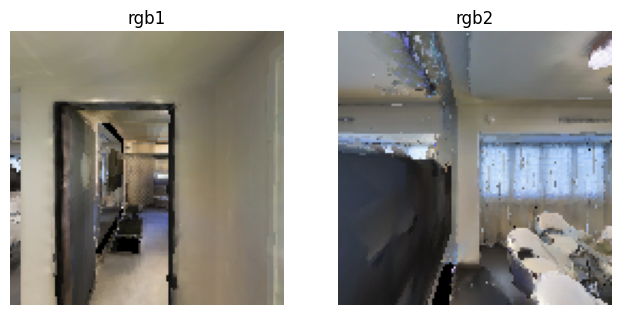

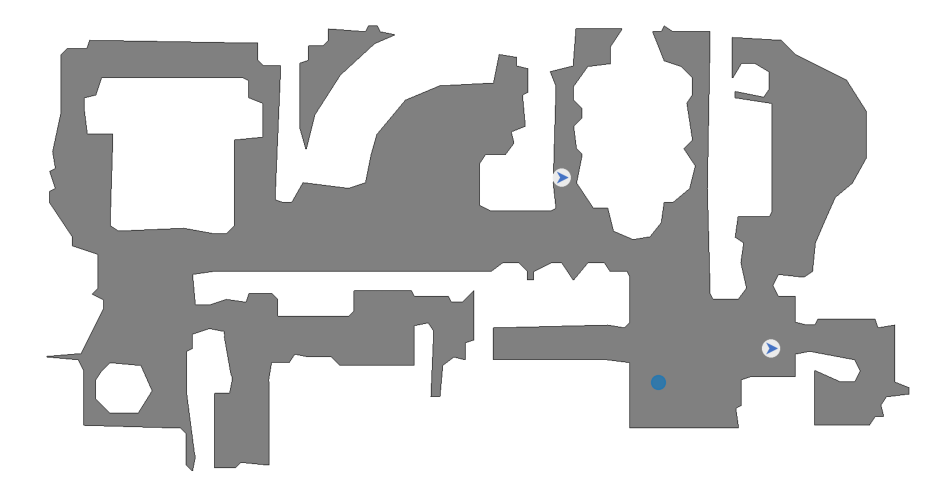

agent 0 turn_left
agent 1 turn_right
[08:22:07:672223]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(1.79197, 0.072447, 0.577634) ], rotQuat[ Vector(0.965926, 0, 0.258819, 0) ]
[08:22:07:672266]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:07:672272]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:09:309408]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.89052, 0.072447, -2.42855) ], rotQuat[ Vector(0.965926, 0, -0.258819, 0) ]
[08:22:09:309469]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:09:309480]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


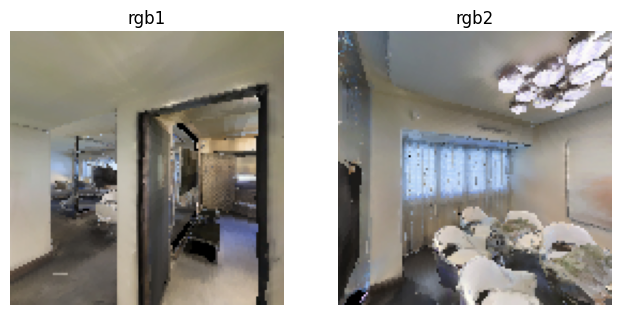

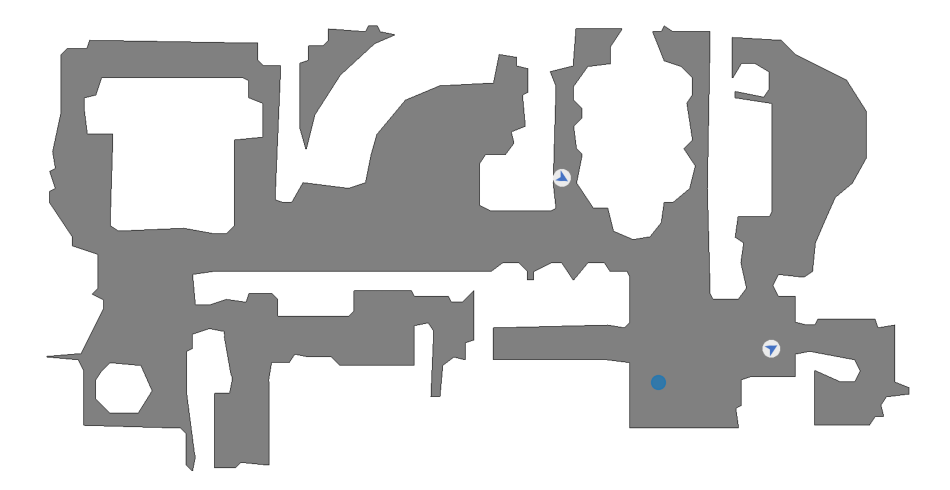

agent 0 turn_left
agent 1 turn_right
[08:22:12:693116]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(1.79197, 0.072447, 0.577634) ], rotQuat[ Vector(0.866025, 0, 0.5, 0) ]
[08:22:12:693177]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:12:693188]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:14:291546]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.89052, 0.072447, -2.42855) ], rotQuat[ Vector(0.866025, 0, -0.5, 0) ]
[08:22:14:291591]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:14:291597]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


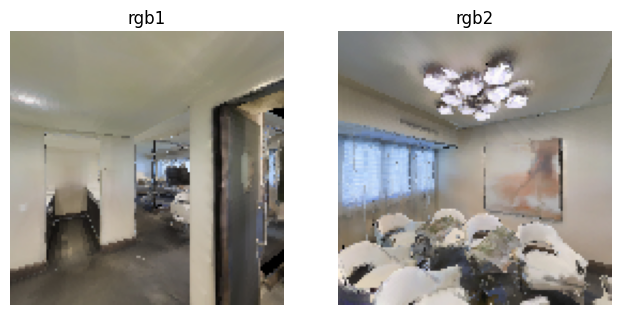

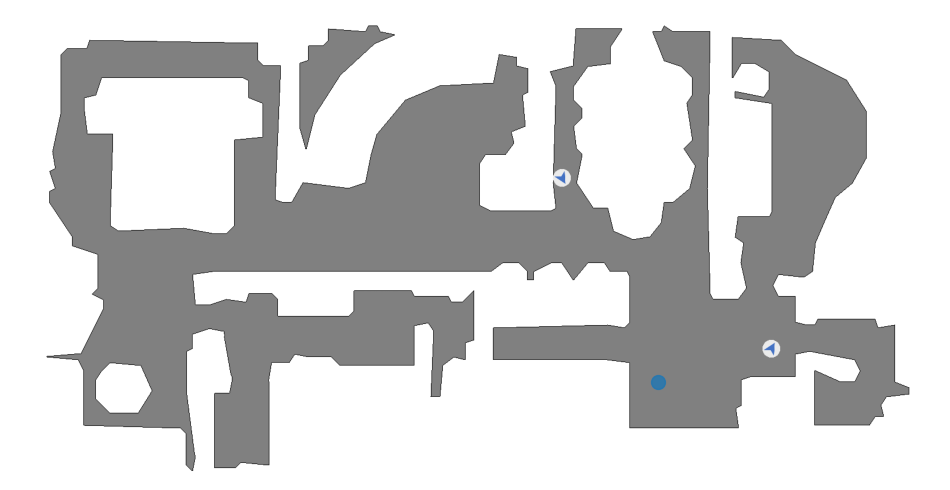

agent 0 turn_left
agent 1 turn_right
[08:22:17:042189]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(1.79197, 0.072447, 0.577634) ], rotQuat[ Vector(0.707107, 0, 0.707107, 0) ]
[08:22:17:042230]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:17:042238]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:18:715341]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.89052, 0.072447, -2.42855) ], rotQuat[ Vector(0.707107, 0, -0.707107, 0) ]
[08:22:18:715385]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:18:715391]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


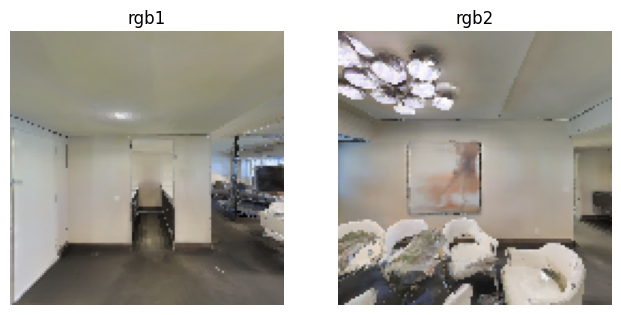

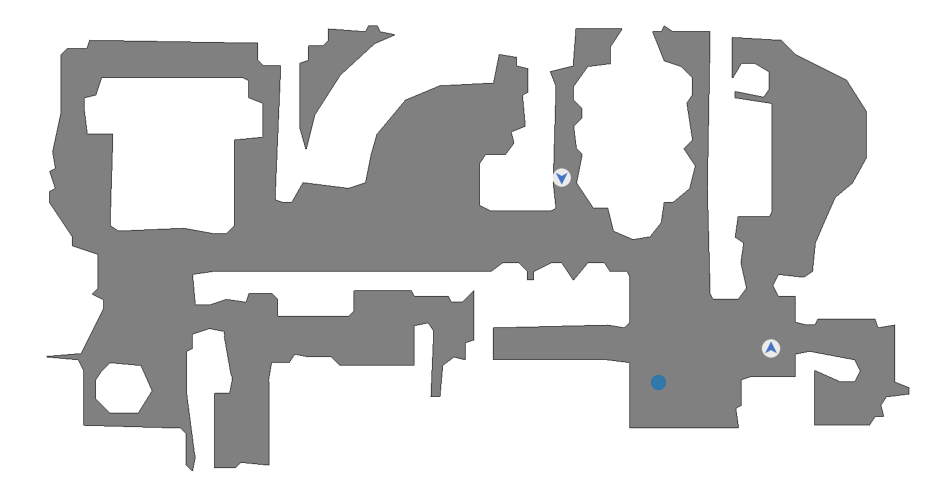

agent 0 move_forward
agent 1 turn_right
[08:22:21:499421]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(1.29197, 0.072447, 0.577634) ], rotQuat[ Vector(0.707107, 0, 0.707107, 0) ]
[08:22:21:499463]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:21:499470]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:23:106740]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.89052, 0.072447, -2.42855) ], rotQuat[ Vector(0.5, 0, -0.866025, 0) ]
[08:22:23:106780]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:23:106785]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


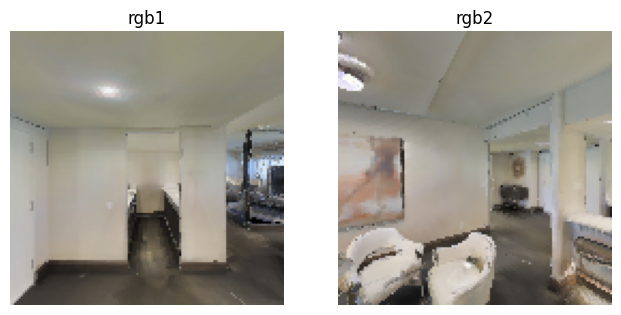

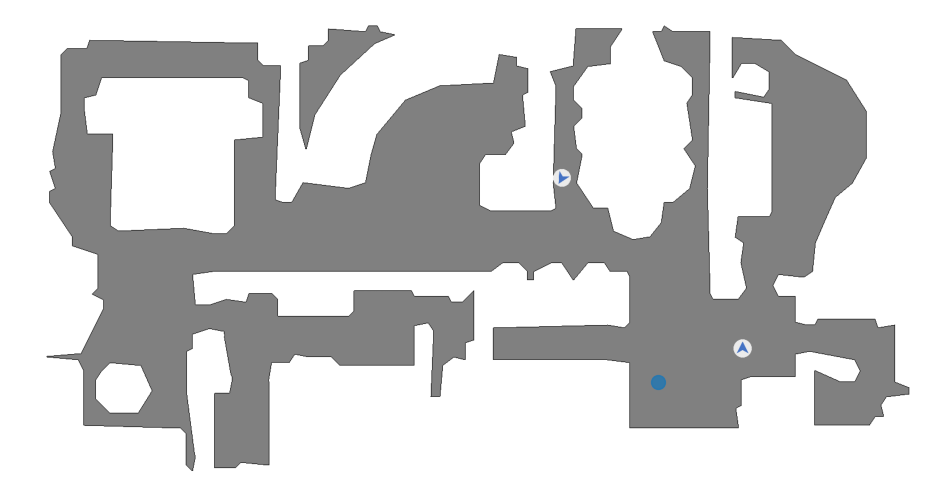

agent 0 turn_left
agent 1 turn_right
[08:22:25:878206]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(1.29197, 0.072447, 0.577634) ], rotQuat[ Vector(0.5, 0, 0.866025, 0) ]
[08:22:25:878250]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:25:878256]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:27:485191]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.89052, 0.072447, -2.42855) ], rotQuat[ Vector(0.258819, 0, -0.965926, 0) ]
[08:22:27:485230]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:27:485236]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


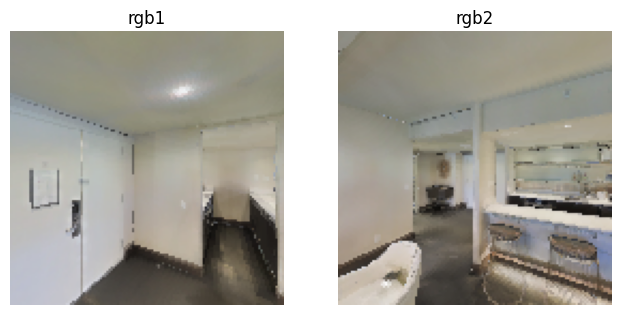

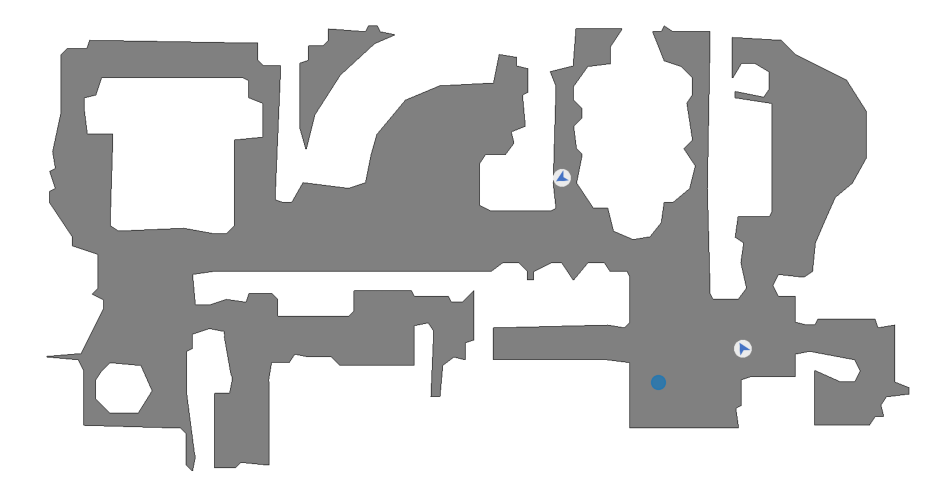

agent 0 move_forward
agent 1 move_forward
[08:22:30:396203]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(0.858953, 0.072447, 0.827634) ], rotQuat[ Vector(0.5, 0, 0.866025, 0) ]
[08:22:30:396244]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:30:396251]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:32:018997]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.64052, 0.072447, -1.99554) ], rotQuat[ Vector(0.258819, 0, -0.965926, 0) ]
[08:22:32:019038]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:32:019044]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


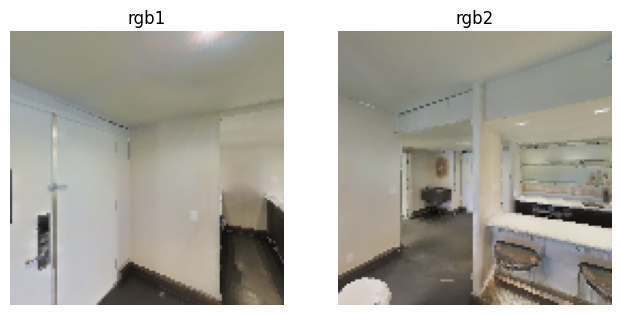

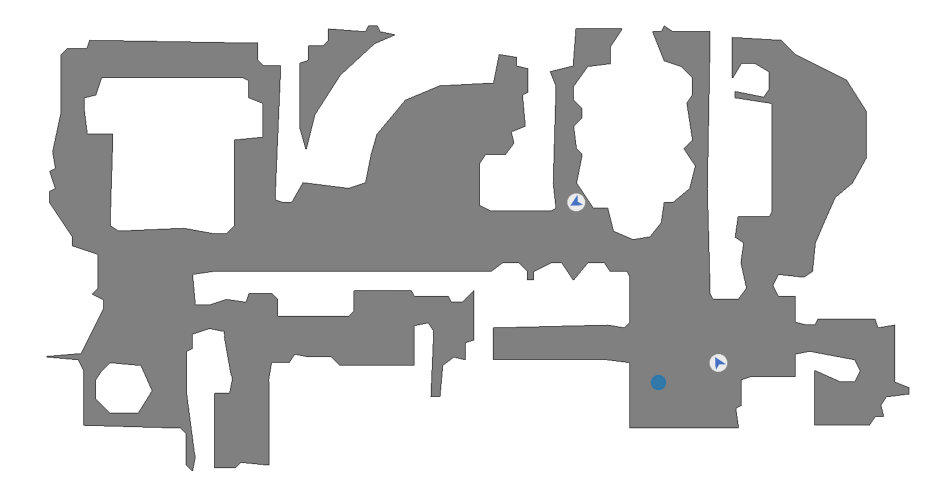

agent 0 move_forward
agent 1 move_forward
[08:22:35:238113]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(0.42594, 0.072447, 1.07763) ], rotQuat[ Vector(0.5, 0, 0.866025, 0) ]
[08:22:35:238172]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:35:238183]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:37:211132]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.39052, 0.072447, -1.56253) ], rotQuat[ Vector(0.258819, 0, -0.965926, 0) ]
[08:22:37:211176]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:37:211181]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


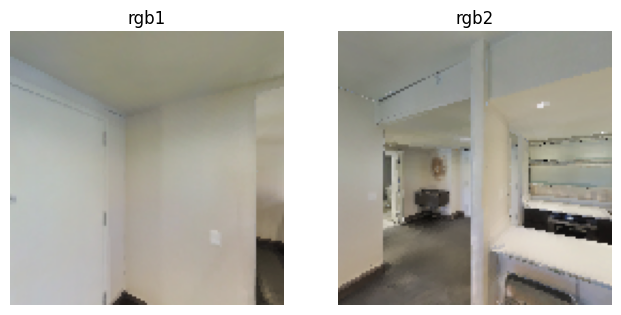

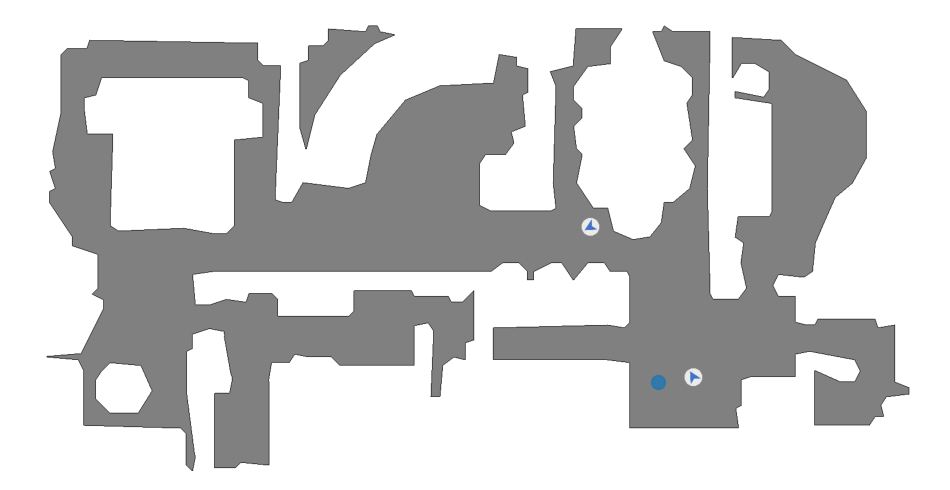

agent 0 stop
agent 1 move_forward
[08:22:40:036260]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(0.42594, 0.072447, 1.07763) ], rotQuat[ Vector(0.5, 0, 0.866025, 0) ]
[08:22:40:036304]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:40:036311]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[08:22:41:696486]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-1.14052, 0.072447, -1.12952) ], rotQuat[ Vector(0.258819, 0, -0.965926, 0) ]
[08:22:41:696528]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[08:22:41:696533]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator


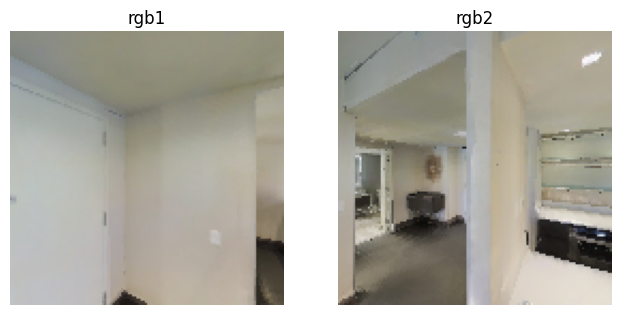

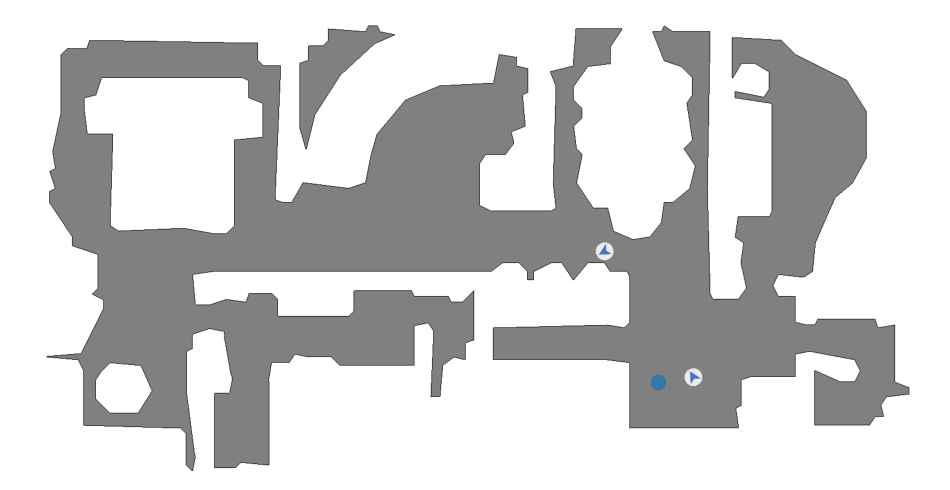

In [21]:
for i in range(10):
        _idx = 0
        obs = env.reset()
        display_obs(obs)
        show_graph(env)
        paths = env.get_shortest_action_list()
        for i in range(len(paths[0])):
                rl_output_list = act(env,paths,_idx)
                
                all_list = env.step(rl_output_list)
                display_obs(all_list[0])
                show_graph(env)
                _idx+=1
        print("回合结束！")
